In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
import keras.models as models
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np

# Descrete + Descrete
### Test whether we can impose two descrete condtions for the outcome (digit + color inversion)

First, try using Embedding multiplicaton method

In [2]:
(X_train, y_train), (_, _) = mnist.load_data()
# Configure input
X_train = (X_train.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1) why?
# reverse color
X_train_inv = -(X_train.astype(np.float32))

X_train = np.concatenate([X_train, X_train_inv])
y_train_1 = np.concatenate([np.zeros_like(y_train), np.ones_like(y_train)])
y_train = np.concatenate([y_train, y_train])

# X_train = np.expand_dims(X_train, axis=3)
#y_train = y_train.reshape(-1, 1)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
class CGAN_2Desc():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.num_classes2 = 2
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise, the target label, and the color inv as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        inv = Input(shape=(1,))
        img = self.generator([noise, label, inv])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label and inv of that image
        valid = self.discriminator([img, label, inv])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label, inv], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=Adam(0.0002, 0.5))

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        inv = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        inv_embedding = Flatten()(Embedding(self.num_classes2, self.latent_dim)(inv))

        model_input = multiply([noise, label_embedding])
        model_input1 = multiply([model_input, inv_embedding])

        img = model(model_input1)

        return Model([noise, label, inv], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        inv = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        inv_embedding = Flatten()(Embedding(self.num_classes2, np.prod(self.img_shape))(inv))

        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])
        model_input1 = multiply([model_input, inv_embedding])

        validity = model(model_input1)

        return Model([img, label, inv], validity)

    def train(self, epochs, batch_size=32, sample_interval=500):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1)
        X_train_inv = -(X_train.astype(np.float32))  # reverse color

        X_train = np.concatenate([X_train, X_train_inv])
        y_train_1 = np.concatenate([np.zeros_like(y_train), np.ones_like(y_train)]) # inv labels
        y_train = np.concatenate([y_train, y_train])  # digit labels

        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels, invs = X_train[idx], y_train[idx], y_train_1[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels, invs])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels, invs], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels, invs], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
            sampled_labels1 = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels, sampled_labels1], valid)

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.concatenate([[0]*5,[1]*5]) ):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        #sampled_labels = np.arange(0, 10).reshape(-1, 1)
        gen_imgs = self.generator.predict([noise, sampled_labels, sampled_labels1])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap= 'gray' ) #cmap='binary'
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt]+'\n'+'Color: %d'% sampled_labels1[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % epoch)
        plt.show()
        plt.close()


# if __name__ == '__main__':
#     cgan = CGAN()
#     cgan.train(epochs=20000, batch_size=32, sample_interval=200)

In [4]:
cgan = CGAN_2Desc()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

0 [D loss: 0.675621, acc.: 44.53%] [G loss: 0.808598]


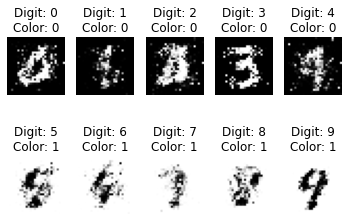

1000 [D loss: 0.671977, acc.: 52.34%] [G loss: 0.884724]


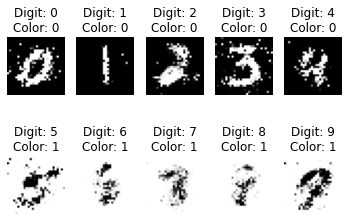

2000 [D loss: 0.645211, acc.: 59.38%] [G loss: 0.812623]


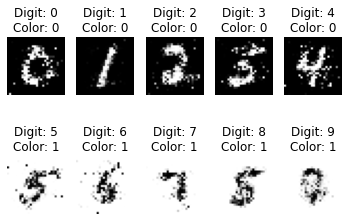

3000 [D loss: 0.629446, acc.: 58.59%] [G loss: 0.846687]


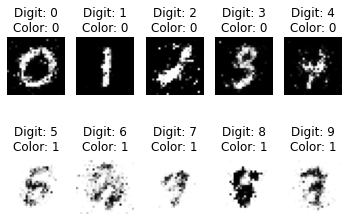

4000 [D loss: 0.665606, acc.: 51.56%] [G loss: 1.047695]


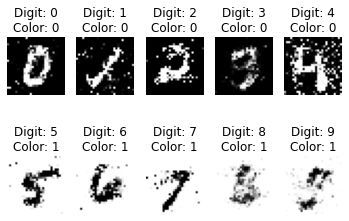

In [8]:
cgan.train(epochs=5000, batch_size=64, sample_interval=1000)

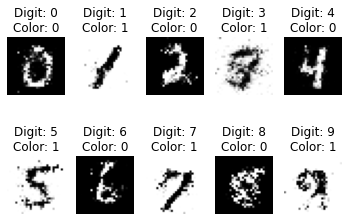

In [9]:
# For prediction
cgan.sample_images(0,np.array(range(10)).reshape(-1,1), np.array([[0,1]*5]).reshape(-1,1))

In [ ]:
# Save Model
#cgan.generator.save('cgan_gen')
#reconstructed_gen = models.load_model("cgan_gen")

In [ ]:
reconstructed_gen.compile(loss=['binary_crossentropy'], optimizer=Adam(0.0002, 0.5))

In [ ]:
# For pickleing
import pickle
# with open('cgan_gen_weights.pickle', 'wb') as handle:
#     pickle.dump(cgan.generator.weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# To recover
# with open('cgan_gen_weights.pickle', 'rb') as handle:
#     recovered_weights = pickle.load(handle)

# Descret + Descre 2
We not implement the conditoning with Conatenation methods

In [4]:
class CGAN_2Desc2():
    def __init__(self, X_train= None, y_train = None):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.num_classes2 = 2
        self.latent_dim = 100
        self.X_train = X_train
        self.y_train = y_train

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise, the target label, and the color inv as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,))
        inv = Input(shape=(self.num_classes2,))
        img = self.generator([noise, label, inv])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label and inv of that image
        valid = self.discriminator([img, label, inv])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label, inv], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=Adam(0.0002, 0.5))

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim+ self.num_classes+self.num_classes2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,), dtype='float32')
        inv = Input(shape=(self.num_classes2,), dtype='float32')

        #label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        #inv_embedding = Flatten()(Embedding(self.num_classes2, self.latent_dim)(inv))

        model_input = concatenate([noise, label, inv])
        #model_input1 = multiply([model_input, inv_embedding])

        img = model(model_input)

        return Model([noise, label, inv], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)+ self.num_classes+self.num_classes2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(self.num_classes,), dtype='float32')
        inv = Input(shape=(self.num_classes2,), dtype='float32')
        #label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        #inv_embedding = Flatten()(Embedding(self.num_classes2, np.prod(self.img_shape))(inv))

        flat_img = Flatten()(img)

        model_input = concatenate([flat_img, label, inv])
        #model_input1 = multiply([model_input, inv_embedding])

        validity = model(model_input)

        return Model([img, label, inv], validity)

    def train(self, epochs, batch_size=64, sample_interval=500):

        # Load the dataset
        if self.X_train == self.y_train == None:
            (X_train, y_train), (_, _) = mnist.load_data()
            #y_train_1 = np.concatenate([np.zeros_like(y_train), np.ones_like(y_train)]) # inv labels
        else:
            X_train, y_train = self.X_train, self.y_train
            
        # Configure input
        X_train = (X_train.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1)
        X_train_inv = -(X_train.astype(np.float32))  # reverse color

        X_train = np.concatenate([X_train, X_train_inv])
        y_train_1 = np.concatenate([np.zeros_like(y_train), np.ones_like(y_train)]) # inv labels
        y_train_1 = to_categorical(y_train_1, self.num_classes2)
        y_train = np.concatenate([y_train, y_train])  # digit labels
        y_train = to_categorical(y_train, self.num_classes)

        X_train = np.expand_dims(X_train, axis=3)
        #y_train = y_train.reshape(-1, 1)
        #y_train_1 = y_train_1.reshape(-1,1)


        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels, invs = X_train[idx], y_train[idx], y_train_1[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels, invs])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels, invs], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels, invs], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels =  labels # to_categorical( np.random.randint(0, 10, batch_size) #.reshape(-1, 1)
            sampled_labels1 = invs #to_categorical(np.random.randint(0, 2, batch_size)) #.reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels, sampled_labels1], valid)

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch, sampled_labels[:10], to_categorical(np.concatenate([[0]*5,[1]*5])) )

    def sample_images(self, epoch, sampled_labels = to_categorical(np.arange(0, 10), 10), sampled_labels1 = to_categorical(np.concatenate([[0]*5,[1]*5]), 2), test = False):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        #sampled_labels = to_categorical(np.arange(0, 10)) #.reshape(-1, 1)
        gen_imgs = self.generator.predict([noise, sampled_labels, sampled_labels1])

        if test == False:
            digits = [np.where(r==1)[0][0] for r in sampled_labels]
        else:
            digits = list(range(r*c))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap= 'gray' ) #cmap='binary'
                axs[i,j].set_title("Digit: %d" % digits[cnt]+'\n'+'Color: %d'% sampled_labels1[cnt][0])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % epoch)
        plt.show()
        plt.close()


# if __name__ == '__main__':
#     cgan = CGAN()
#     cgan.train(epochs=20000, batch_size=32, sample_interval=200)

In [5]:
(X_train, y_train), (_, _) = mnist.load_data()
cgan2 = CGAN_2Desc2(X_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               408064    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0 [D loss: 0.568046, acc.: 67.19%] [G loss: 1.169352]


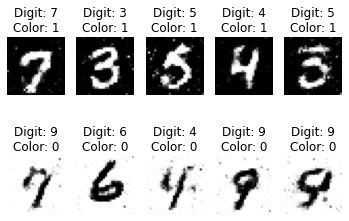

KeyboardInterrupt: ignored

In [7]:
cgan2.train(10000, batch_size= 64, sample_interval= 1000)

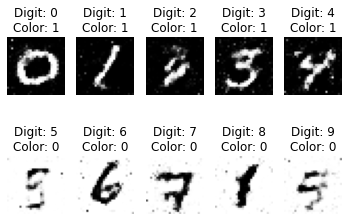

In [23]:
sampled_labels = to_categorical(np.arange(0, 10), 10) 
sampled_labels1 = to_categorical(np.concatenate([[0]*5,[1]*5]), 2)
cgan2.sample_images(0,sampled_labels, sampled_labels1)

## Testing for disentanglement
To test the model has learned representaion with features that are disentagled, we train a model with the same configuration as before but at the testing time, we will replace one of the conditions with random noise and observe if other condition will be reflected or not. 

 Below changes just the color. For the most part the digit is preserved.

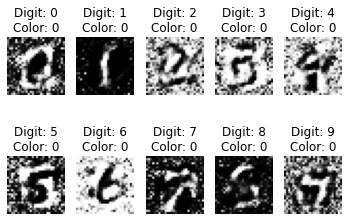

In [27]:
sampled_labels = to_categorical(np.arange(0, 10), 10) 
sampled_labels1 = np.random.rand(10,2) #to_categorical(np.concatenate([[0]*5,[1]*5]), 2)
cgan2.sample_images(1,sampled_labels, sampled_labels1)

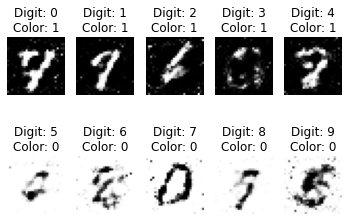

In [33]:
sampled_labels = np.random.rand(10,10) #to_categorical(np.arange(0, 10), 10)
sampled_labels1 = to_categorical(np.concatenate([[0]*5,[1]*5]), 2)

cgan2.sample_images(2,sampled_labels, sampled_labels1, test = True)

In [63]:
cgan2.generator.save('./drive/MyDrive/digit_inv_gen')

INFO:tensorflow:Assets written to: ./drive/MyDrive/digit_inv_gen/assets


In [86]:
import PIL
from PIL import Image
def gen_image(arr):
    """
    from (0,1) to (0, 255)
    """
    arr = np.array(arr)
    h, w = arr.shape[0], arr.shape[1]
    two_d = (np.reshape(arr, (h, w))).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img